#### Homework 2
#### Scripting for Data Analysis
#### 8/26/2018

For this assignment, I will be using jupyter notebooks to perform my analysis, as well as my writeup. I find the structure of having all written exploration and all code in one place helps to digest some material, as well as allowing for rapid prototyping and quick changes.


The goal of this assignment is to read in some form of JSON data, whether that be from an API like tweepy, or straight from a mongodb. I'd like to consolidate the two, just to get some more practice using a document store like pymongo as well as a social media API, which I have worked with in the past, but know have a bit more practice dissecting lists of dictionaries. I also might explore using a pretrained sentiment analysis model (NLTK) to show some notion of a distribution between positive and negative sentiment over time - I've found this to be a sometimes viable source for mass labeling datasets, although there is a bit of a negative bias when using NLTK (bias is unavoidable when dealing with human annotation tasks).



#### Setting up a mongodb connection

In [217]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)  #Set up client

#b.create_collection('tweets')
db.list_collection_names()
client.list_database_names()
client.drop_database('twitter_storage')
client.list_database_names()


['admin', 'config', 'local', 'usgs']

In [218]:
from time import localtime, strftime
import timeit
import time
import pymongo
from pymongo import MongoClient
import warnings

client = MongoClient('localhost', 27017)  #Set up client


def create_db(database, collection_name):
    start = time.time()
    #wasn't sure if this just rewrote over it. I don't believe it does, but that's the rationale for the try-catch
    #borrowed some of the below from the db_fn notebook. Seems like an easier way of handling type sensitivity to just convert after input
    dbname = name.lower()
    dbname = dbname.replace('#', '')
    dbname = dbname.replace(' ', '')
    dbCollection = collect.lower()
    dbCollection = dbCollection.replace('#', '')
    dbCollection = dbCollection.replace(' ', '')
    # use database named usgs or create it if not there already
    db = client[dbname]
    # create collection
    collection = db[dbCollection]
    end = time.time()
    #Logs
    print('DB: |{}| is ready @ {}'.format(
        dbname, strftime("%Y-%m-%d %H:%M:%S", localtime())))
    print('-------------------------')
    print('DBcollection: |{}| is ready @ {}'.format(
        dbCollection, strftime("%Y-%m-%d %H:%M:%S", localtime())))
    print('-------------------------')
    print('Time taken to execute: {} seconds'.format(end - start))


#instantiate
name = 'twitter_storage'
collect = 'tweets'

create_db(name, collect)

#Testing upload
#create_db(name, collect)
#collection.insert_one({'j': 1})
#client.list_database_names()


DB: |twitter_storage| is ready @ 2018-08-26 22:18:21
-------------------------
DBcollection: |tweets| is ready @ 2018-08-26 22:18:21
-------------------------
Time taken to execute: 0.0 seconds


#### Starting with twython
The first step here will be to collect some data from tweepy. I had luckily set up a twitter dev account in a previous class, so I'm taking the keys from that notebook. I'm trying to do focus on functional programming over scripting, so I'm breaking this into some main functions that I want to call. This could then be easily transferred to a .py file and ran.

As far as the actual query, I settled on Donald Trump. I know this is a pretty common project since he's very active on twitter, but I have never explored things like mass-sentiment analysis of an individual based on tweets.




In [219]:
import tweepy

#Likely want to import this in from a separate .py file where possible. Didn't think it was highly sensitive, so left it in here.
consumer_key = 'K3qj35aGWoALJaBdqSUgszqoc'
consumer_secret = 'hyBrGQXXbyTah2btx29di8w92SlgFN9fu48s0KjCJKJpiZI4Zx'
access_token = '1019690305237311488-b04ol1OxAOznie1ir1wWlneoetChYx'
access_token_secret = 'QPc4KDfNraTT5S63kcvu5t8GTL1H5y5MkyE9EZCupvUQD'

q = 'Donald Trump'


def fetch_tweets(query,
                 consumer_key=consumer_key,
                 consumer_secret=consumer_secret,
                 access_token=access_token,
                 access_token_secret=access_token_secret):
    '''
    query: string
    '''

    try:
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        api = tweepy.API(auth)
        placeholder = []

        #This is the cleanest way I could think of doing this.
        #I'm basically trying to bypass the 100 tweet limit by continuing w/ a nested loop until a threshold is reached.
        for i in api.search(q=query, lang="en", count=100):
            placeholder.append(
                i._json
            )  #transforming to json and storing in a list named placeholder
            counter = len(placeholder)
            if counter > 5000:
                break
            else:
                for i in api.search(q=query, lang="en", count=100):
                    placeholder.append(
                        i._json
                    )  #transforming to json and storing in a list named placeholder
                    continue

        print('You have successfully scraped and pulled {} tweets'.format(
            len(placeholder)))
        return placeholder
    except:
        print('Unable to scrape tweets')


tweets = fetch_tweets(
    query='Donald Trump')  #Save an instance with the json data

collection.insert_many(tweets)


You have successfully scraped and pulled 5051 tweets


### From here, I thought it might be interesting to look at the distribution of my 5000+ tweets by location.

This is a bit wonky, but it's definitely a learning experience. It's important to note that the 5k tweets that I pulled came in with a range of a matter of seconds, so showing any kind of time series distribution would be at the 'second' level. That's why I'm avoiding that here. Instead, looking at a distribution of tweet count by region, I can begin to see a sample of the total population. We also start to notice some of the flaws with manual entry form submission for application access - The variation in the manner of responses is inherently flawed. United States and USA are listed as two different Geos. 'God Bless Our Veterans' is listed as a geo in its own regard - That makes me think that people are becoming increasingly aware of the abilities for scrapers and humans alike to form a profile based on their web data.

In [224]:
tweets[0]

times = []
geos = []
text = []

from collections import Counter
#Store data in lists
for i in tweets:
    times.append(i['created_at'])
    geos.append(i['user']['location'])
    text.append(i['text'])

import pandas as pd
#Convert lists to a pandas dataframe for grouping
df = pd.DataFrame()
df['geos'] = geos
df['time'] = times
df['text'] = text

#Group by count of geos
df_geos = df['geos'].groupby(by=geos).count()[1:]
df_geos = pd.DataFrame(df_geos.sort_values(ascending=False)[:10])
df_geos.reset_index(inplace=True)
display(df_geos)

,index,geos
0,USA,172
1,United States,170
2,"Florida, USA",90
3,"North Carolina, USA",80
4,"Nashville, TN",72
5,"California, USA",71
6,European Union 🇪🇺🇩🇪🇨🇮,63
7,"Sydney, New South Wales",57
8,"Tokyo, Japan",51
9,"San Francisco, CA",51


#### Sentiment Analysis
Next, I'd like to show something like the above but with the added twist of some kind of scoring mechanism to show sentiment of tweets by region of the fixed period of time. I don't necessarily want to build my own classifier here, so I'll use a neural net with pretrained weights based off of fitting on social media text. 

- Admittedly, it would have been better for me to do some kind of string match against a list of viable geos across the world. As I moved through this assignment, it made it very difficult to actual do analysis because most users don't enter realistic locations into apps/websites when signing up for service.

In [221]:
#!pip install vaderSentiment
#http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#prime sentiment analyzer
analyser = SentimentIntensityAnalyzer()


#def print_sentiment_scores(sentence):
#    snt = analyser.polarity_scores(sentence)
#    print("{:-<40} {}".format(sentence, str(snt)))


#Append dict scores to a list
empty = []
for i in text:
    empty.append(analyser.polarity_scores(i))

#convert list of dicts to dataframe
polarity = pd.DataFrame(empty)

In [222]:
#Add the columns from the polarity df to the original df with the geo data
df['negative_score'] = polarity['neg']
df['neutral_score'] = polarity['neu']
df['positive_score'] = polarity['pos']

#Group by geos + score
import numpy as np
sent_geo = df.groupby(
    ['geos'])[['negative_score', 'neutral_score', 'positive_score']].sum()[1:]

#Iterate through a list to display sorting by different scores
score_types = ['negative_score', 'neutral_score', 'positive_score']
for i in score_types:
    print('Displaying the top 5 geos, sorted by {} '.format(i))
    display(sent_geo.sort_values(by=i, ascending=False)[:5])

#sent_geo.sort_values(by = 'negative_score', ascending= False)[:5]

Displaying the top 5 geos, sorted by negative_score 


,negative_score,neutral_score,positive_score
geos,,,
USA,21.051,133.523,17.375
San Antonio TX,20.727,18.963,9.310
"Nashville, TN",20.613,46.287,5.100
European Union 🇪🇺🇩🇪🇨🇮,18.235,40.065,4.700
Germany,17.748,29.070,4.182


Displaying the top 5 geos, sorted by neutral_score 


,negative_score,neutral_score,positive_score
geos,,,
United States,12.079,145.783,12.150
USA,21.051,133.523,17.375
"Florida, USA",8.774,81.226,0.000
"North Carolina, USA",4.324,73.058,2.618
"California, USA",5.180,65.820,0.000


Displaying the top 5 geos, sorted by positive_score 


,negative_score,neutral_score,positive_score
geos,,,
USA,21.051,133.523,17.375
"Tokyo, Japan",5.610,30.141,15.249
United States,12.079,145.783,12.150
Wherever Music Is Playing,8.040,20.360,11.600
"Spokane Valley, WA (STATE)",0.000,39.474,11.526


,geos,time,text,negative_score,neutral_score,positive_score
0,"Indiana, USA",Mon Aug 27 05:18:09 +0000 2018,@FaceLess1930 @DineshDSouza i present the man ...,0.0,1.0,0.0


,geos,time,text,negative_score,neutral_score,positive_score,sentiment
0,"Indiana, USA",Mon Aug 27 05:18:09 +0000 2018,@FaceLess1930 @DineshDSouza i present the man ...,0.000,1.000,0.000,neutral
1,,Mon Aug 27 05:18:09 +0000 2018,Obama was the worst President in History!\nPre...,0.148,0.652,0.200,neutral
2,"Indiana, USA",Mon Aug 27 05:18:09 +0000 2018,@FaceLess1930 @DineshDSouza i present the man ...,0.000,1.000,0.000,neutral
3,,Mon Aug 27 05:18:08 +0000 2018,RT @DFBHarvard: You realize there is only ONE ...,0.214,0.786,0.000,neutral
4,United States,Mon Aug 27 05:18:08 +0000 2018,Fox News Host Slams Dotard Don: ‘What Good Is ...,0.099,0.776,0.125,neutral


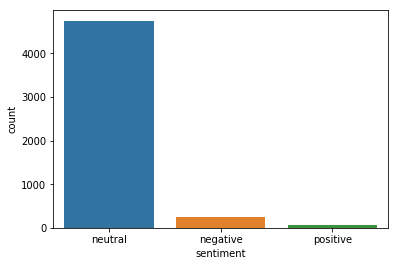

Counter({'negative': 246, 'neutral': 4748, 'positive': 57})

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
display(df.head(1))

#Conditional Logic to create new var based on treshold
df['sentiment'] = np.where(df['negative_score'] >= 0.33, 'negative',
                          np.where(df['positive_score'] >= 0.33, 'positive',
                                  np.where(df['neutral_score'] >= 0.33, 'neutral', 0)))

display(df.head(5))

#Plotting sentiment count by cat var
sns.countplot(x = 'sentiment', data = df)
plt.show()
from collections import Counter
Counter(df['sentiment'])


#### In conclusion

This was a very interesting, fun project. I spent the better part of two days researching and writing the code that led to this point. I also had some serious debugging issues that set me back, but ultimately helped me troubleshoot what was going on in my code. In terms of the actual results, they were very surprising, regarding the sentiment analysis portion of the task. I assumed that most of the tweets that were scraped would have a negative connotation, and it is possible that the Saber pretrained NN has some inherent bias towards neutral class mapping, but still, having over 90% of the tweets fall under that class is something. It should be noted that these tweets were pulled within about a one minute span of one another, so they aren't distributed over a number of days. To do that I imagine we could just run a daily job, similar to this, and store all of the documents in our mongodb (That's kind of why I included that part, as well as just refamiliarizing myself with the API). 